In [2]:
import gzip
from lxml import objectify
import pandas as pd
import numpy as np
import dateutil.parser
import datetime

# https://nvd.nist.gov/download.cfm

El primer paso es abrir el zip del año 2002, utilizando gzip. De esta manera, el contenido del zip (XML) se abre y se almacena en una variable. Posteriormente esa variable se convierte a objeto XML para recorrerla más adelante.

In [3]:
with gzip.open('nvdcve-2.0-2002.xml.gz', 'rb') as f:
    file_content = f.read()
parsed = objectify.fromstring(file_content)

Se inicializan todas las listas que contendrán los nodos que se desean recoger y analizar.

In [4]:
entry_ID = []
cve_ID = []
published_datetime = []
last_modified_datetime = []
score  = []
access_vector_score = []
access_complexity_score = []
authentication_score = []
confidentiality_impact_score = []
integrity_impact_score = []
availability_impact_score = []
source = []
generated_on_datetime = []
cwe_id = []
summary = []


La gran mayoría de los nodos contienen namespace, así que se definen para concatenarlos después con el nombre del tag del nodo deseado.

In [5]:
# for namespaces
vuln_ns = "{http://scap.nist.gov/schema/vulnerability/0.4}"
cvss_ns = "{http://scap.nist.gov/schema/cvss-v2/0.2}"

Se recorre cada una de las entradas, y para cada una de ellas, se obtiene:
* Entry_ID
* CVE_ID
* Published datetime
* Last modified datetime
* CVSS
    * General score
    * Access vector
    * Access complexity
    * Authentication
    * Confidentiality impact
    * Integrity impact
    * Source
    * Generated on datetime
* CWE
* Summary

In [6]:
for row in parsed.entry:
    
    
    entry_ID.append(str(row.attrib.get("id")))
    cve_ID.append(str(row[vuln_ns+"cve-id"]))
    published_datetime.append(dateutil.parser.parse(str(row[vuln_ns+"published-datetime"])).date())
    last_modified_datetime.append(dateutil.parser.parse(str(row[vuln_ns+"last-modified-datetime"])).date())
    
    if row.find(vuln_ns+"cvss") is not None:
        score_node = row[vuln_ns+"cvss"][cvss_ns+"base_metrics"]


        score.append(float(score_node[cvss_ns+"score"]))
        access_vector_score.append(str(score_node[cvss_ns+"access-vector"]))
        access_complexity_score.append(str(score_node[cvss_ns+"access-complexity"]))
        authentication_score.append(str(score_node[cvss_ns+"authentication"]))
        confidentiality_impact_score.append(str(score_node[cvss_ns+"confidentiality-impact"]))
        integrity_impact_score.append(str(score_node[cvss_ns+"integrity-impact"]))
        availability_impact_score.append(str(score_node[cvss_ns+"availability-impact"]))
        source.append(str(score_node[cvss_ns+"source"]))
        generated_on_datetime.append(str(score_node[cvss_ns+"generated-on-datetime"]))
    else:
        score.append(np.nan)
        access_vector_score.append(np.nan)
        access_complexity_score.append(np.nan)
        authentication_score.append(np.nan)
        confidentiality_impact_score.append(np.nan)
        integrity_impact_score.append(np.nan)
        availability_impact_score.append(np.nan)
        source.append(np.nan)
        generated_on_datetime.append(np.nan)
    
    if row.find(vuln_ns+"cwe") is not None:
        cwe_id.append(str(row[vuln_ns+"cwe"].attrib.get("id")))
    else:
        cwe_id.append(np.nan)
        
    
    summary.append(str(row[vuln_ns+"summary"]))
    # print(row.attr)
    

Todas esas listas conformarán las futuras columnas del data frame de pandas.

In [7]:
data = pd.DataFrame()
data['entry_ID'] = entry_ID
data['cve_ID'] = cve_ID
data['published_datetime'] = published_datetime 
data['last_modified_datetime'] = last_modified_datetime
data['score'] = score
data['access_vector_score'] = access_vector_score
data['access_complexity_score'] = access_complexity_score
data['authentication_score'] = authentication_score
data['confidentiality_impact_score'] = confidentiality_impact_score
data['integrity_impact_score'] = integrity_impact_score
data['availability_impact_score'] = availability_impact_score
data['source'] = source
data['generated_on_datetime'] = generated_on_datetime
data['cwe_id'] = cwe_id
data['summary'] = summary

Primero se echa un vistazo al dataframe obtenido, indicando, por ejemplo, el número de entradas que tiene.

In [8]:
print(len(data["entry_ID"]))
data.head()

6721


,entry_ID,cve_ID,published_datetime,last_modified_datetime,score,access_vector_score,access_complexity_score,authentication_score,confidentiality_impact_score,integrity_impact_score,availability_impact_score,source,generated_on_datetime,cwe_id,summary
0,CVE-1999-0001,CVE-1999-0001,1999-12-30,2010-12-16,5.0,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,http://nvd.nist.gov,2004-01-01T00:00:00.000-05:00,CWE-20,ip_input.c in BSD-derived TCP/IP implementatio...
1,CVE-1999-0002,CVE-1999-0002,1998-10-12,2009-01-26,10.0,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,http://nvd.nist.gov,2004-01-01T00:00:00.000-05:00,CWE-119,Buffer overflow in NFS mountd gives root acces...
2,CVE-1999-0003,CVE-1999-0003,1998-04-01,2008-09-09,10.0,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,http://nvd.nist.gov,2004-01-01T00:00:00.000-05:00,NaN,Execute commands as root via buffer overflow i...
3,CVE-1999-0004,CVE-1999-0004,1997-12-16,2008-09-09,5.0,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,http://nvd.nist.gov,2004-01-01T00:00:00.000-05:00,NaN,"MIME buffer overflow in email clients, e.g. So..."
4,CVE-1999-0005,CVE-1999-0005,1998-07-20,2008-09-09,10.0,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,http://nvd.nist.gov,2004-01-01T00:00:00.000-05:00,NaN,Arbitrary command execution via IMAP buffer ov...


Una de las columnas más importantes es la de la fecha de publicación. Se va a ordenar esa fecha de publicación de forma ascendente para observar si hay valores que puedan resultar extraños.

In [9]:
ordered_date = data.sort("published_datetime")
ordered_date["published_datetime"]

/home/migueld/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


94      1988-10-01
81      1988-11-11
1450    1989-01-01
1101    1989-07-26
1446    1989-10-26
1485    1990-01-29
83      1990-05-01
1960    1990-05-09
207     1990-08-14
1177    1990-10-03
1371    1990-10-03
1370    1990-10-03
1036    1990-10-25
1533    1990-10-31
1176    1990-12-20
1094    1990-12-31
1237    1991-01-15
1417    1991-02-22
1191    1991-03-27
1190    1991-03-27
1173    1991-05-01
1172    1991-05-14
1102    1991-05-20
1013    1991-05-23
1394    1991-08-23
1069    1991-09-10
495     1991-09-27
1447    1991-10-22
166     1991-12-06
1472    1991-12-18
           ...    
1352    2005-01-05
1410    2005-01-07
4183    2005-05-02
1536    2005-05-02
1353    2005-05-02
4975    2005-05-02
5652    2005-05-02
1572    2009-01-14
6711    2009-02-06
6710    2009-02-06
6709    2009-02-06
6708    2009-02-06
6707    2009-02-06
4346    2010-02-12
2806    2010-04-05
6713    2010-04-05
4347    2010-04-05
6714    2010-04-05
2807    2010-04-05
6712    2010-04-05
2808    2011-10-04
6716    2011

Como se ve, para ser un dataset hasta el año 2002, contiene registros de años 2003, 2009...2016. Esos registros hay que descartarlos.

In [10]:
data = data[data["published_datetime"]<datetime.date(2003,1,1)]
ordered_date = data.sort_values("published_datetime")
ordered_date["published_datetime"].tail()

6176    2002-12-31
6177    2002-12-31
6178    2002-12-31
6180    2002-12-31
6706    2002-12-31
Name: published_datetime, dtype: object

Otra de las columnas de mayor importancia del dataset es la columna de puntuación (score). Es buena recomendación observar sus diferentes valores para ver si alguno puede ser incorrecto. También, realizar su histograma indicará la frecuencia con la que aparecen los distintos valores:

[  5.   10.    7.5   7.2   nan   4.6   2.6   5.1   7.1   6.4   1.9   2.1
   3.7   7.6   6.2   6.8   7.8   9.3   1.2   0.    4.9   4.    3.6   4.3
   9.    3.5   5.4   1.7   3.8   8.5   8.3   6.6   9.4   6.9   3.3   5.8
   8.8]


(array([   20.,    53.,   477.,    62.,   552.,  2013.,   199.,  2349.,
            3.,   697.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

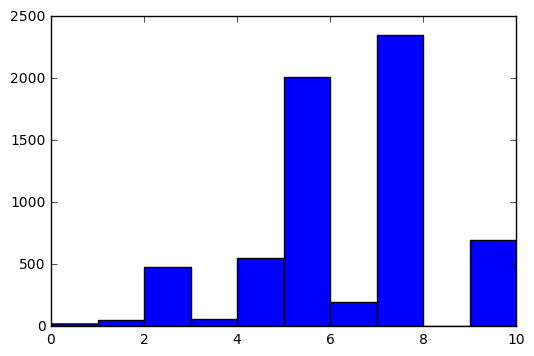

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
print(data["score"].unique())
plt.hist(data["score"].dropna())

Se muestra que efectivamente hay datos erróneos y el histograma muestra que es sesgado positivamente, es decir, que hay más valores hacia la derecha que hacia la izquierda. Se puede apreciar a primera vista que hay un mayor número de vulnerabilidades de alto riesgo que de bajo, y que el valor que más se repite se encuentra entre el 7 y el 8.

Ahora se realizará un diagrama que represente la evolución de las puntuaciones a lo largo del tiempo. A esa gráfica se ha añadido:
* Una línea horizontal roja indicando la mitad del valor máximo de los datos (un 5)
* Una línea horizontal amarilla indicando la media de las puntuaciones.
* Una línea horizontal verde indicando la mediana de las puntuaciones.

In [12]:
score_data = data[["score","published_datetime"]].dropna()
print("Valores nulos eliminados!")

Valores nulos eliminados!


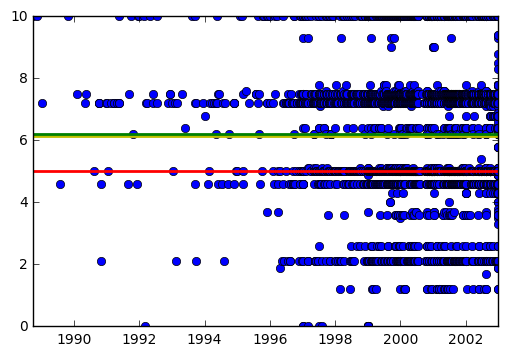

In [13]:
ordered_date = score_data.sort_values("published_datetime")

plt.plot(ordered_date["published_datetime"], ordered_date["score"], 'o', color='blue')
plt.axhline(5, color='r', lw=2)
plt.axhline(np.mean(ordered_date["score"]), color='y', lw=2)
plt.axhline(np.median(ordered_date["score"]), color='g', lw=2)

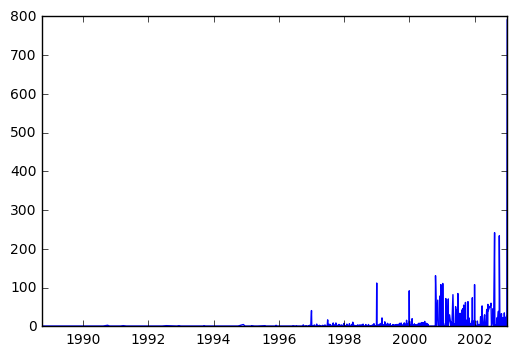

In [14]:
count_score = score_data.sort_values("published_datetime").groupby("published_datetime").count()
plt.plot(count_score)

La gran mayoría de los valores de puntuación se encuentran entre el 6 y el 8 (acorde con el histograma mostrado con anterioridad). Los valores de media y mediana son muy próximos. Un aspecto importante a destacar es la cantidad de datos por cada año. Se aprecia un crecimiento prácticamente exponencial.

A continuación se va a analizar hasta qué punto impacta uno de los atributos, la complejidad de acceso, sobre la puntuación final. Por ejemplo, ¿si tiene menor complejidad de acceso, implica que será más peligroso? ¿Tiene más impacto sobre la puntuación final que otros atributos?

En este primer ejemplo se va a desglosar la complejidad de acceso en sus tres valores posibles: LOW, MEDIUM y HIGH. Se va a realizar la misma gráfica que en el anterior apartado solo que desglosando en esos tres valores:

Low score (more vulnerable) mean: 6.27707985299
Medium score mean: 5.21616766467
High score (less vulnerable) mean: 4.14301470588
------------
Low score (more vulnerable) count: 5986
Medium score count: 167
High score (less vulnerable) count: 272


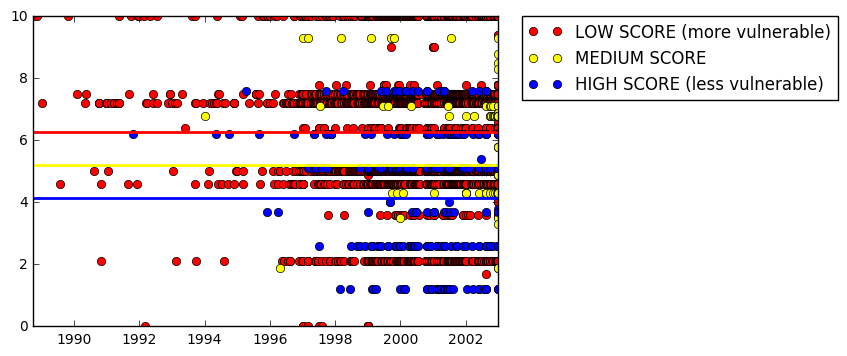

In [15]:
acc_compl = data[["score", "published_datetime", "access_complexity_score"]].dropna().sort_values("published_datetime")

low_data = acc_compl[acc_compl["access_complexity_score"] == "LOW"]
medium_data = acc_compl[acc_compl["access_complexity_score"] == "MEDIUM"]
high_data = acc_compl[acc_compl["access_complexity_score"] == "HIGH"]


plt.plot(low_data["published_datetime"], low_data["score"], 'o', color='red')
plt.plot(medium_data["published_datetime"], medium_data["score"], 'o', color='yellow')
plt.plot(high_data["published_datetime"], high_data["score"], 'o', color='blue')
plt.legend(["LOW SCORE (more vulnerable)","MEDIUM SCORE","HIGH SCORE (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(low_data["score"]), color='red', lw=2)
plt.axhline(np.mean(medium_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(high_data["score"]), color='blue', lw=2)

print("Low score (more vulnerable) mean: " + str(np.mean(low_data["score"])))
print("Medium score mean: " + str(np.mean(medium_data["score"])))
print("High score (less vulnerable) mean: " + str(np.mean(high_data["score"])))


print("------------")

print("Low score (more vulnerable) count: " + str(low_data["score"].count()))
print("Medium score count: " + str(medium_data["score"].count()))
print("High score (less vulnerable) count: " + str(high_data["score"].count()))

Como se observa, existe una gran cantidad de valores aportado por complejidades de acceso bajas (más vulnerables). Se aprecia que la gran mayoría de valores con complejidad de acceso baja se incluyen dentro de puntuaciones finales muy altas, entre 7 y 10. Sin embargo, también existe un considerable número de valores de puntuación baja cuando la complejidad de acceso es alta, por lo que no se puede asegurar con certeza que tenga un impacto inmediato.

El desglose anterior muestra la gran diferencia entre valores altos, medios y bajos. Si se realiza una cuenta, se observa que efectivamente los valores de acceso bajos son los más recurrentes y, por tanto, los que más impactan dentro de esa variable de complejidad de acceso.

In [16]:
data["access_vector_score"].unique()

array(['NETWORK', 'LOCAL', nan], dtype=object)

Network score (more vulnerable) mean: 6.59369639794
Adjacent network score mean: nan
Local score (less vulnerable) mean: 5.0082907439
------------
Network score (more vulnerable) count: 4664
Adjacent network score count: 0
Local score (less vulnerable) count: 1761


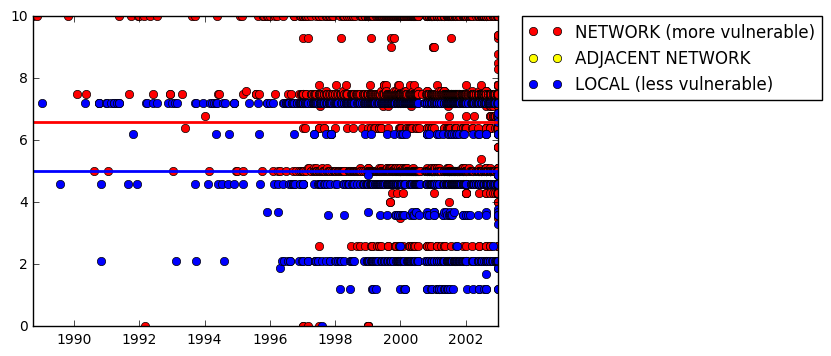

In [17]:
acc_vect = data[["score", "published_datetime", "access_vector_score"]].dropna().sort_values("published_datetime")

local_data = acc_vect[acc_vect["access_vector_score"] == "LOCAL"]
adjacent_data = acc_vect[acc_vect["access_vector_score"] == "ADJACENT NETWORK"]
network_data = acc_vect[acc_vect["access_vector_score"] == "NETWORK"]


plt.plot(network_data["published_datetime"], network_data["score"], 'o', color='red')
plt.plot(adjacent_data["published_datetime"], adjacent_data["score"], 'o', color='yellow')
plt.plot(local_data["published_datetime"], local_data["score"], 'o', color='blue')
plt.legend(["NETWORK (more vulnerable)","ADJACENT NETWORK","LOCAL (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(network_data["score"]), color='red', lw=2)
plt.axhline(np.mean(adjacent_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(local_data["score"]), color='blue', lw=2)

print("Network score (more vulnerable) mean: " + str(np.mean(network_data["score"])))
print("Adjacent network score mean: " + str(np.mean(adjacent_data["score"])))
print("Local score (less vulnerable) mean: " + str(np.mean(local_data["score"])))

print("------------")

print("Network score (more vulnerable) count: " + str(network_data["score"].count()))
print("Adjacent network score count: " + str(adjacent_data["score"].count()))
print("Local score (less vulnerable) count: " + str(local_data["score"].count()))

In [18]:
data["authentication_score"].unique()

array(['NONE', nan, 'SINGLE_INSTANCE'], dtype=object)

None score (more vulnerable) mean: 6.15958508813
Single instance score mean: 5.96428571429
Multiple instance (less vulnerable) mean: nan
------------
None score (more vulnerable) count: 6411
Single instance score count: 14
Multiple instance (less vulnerable) count: 0


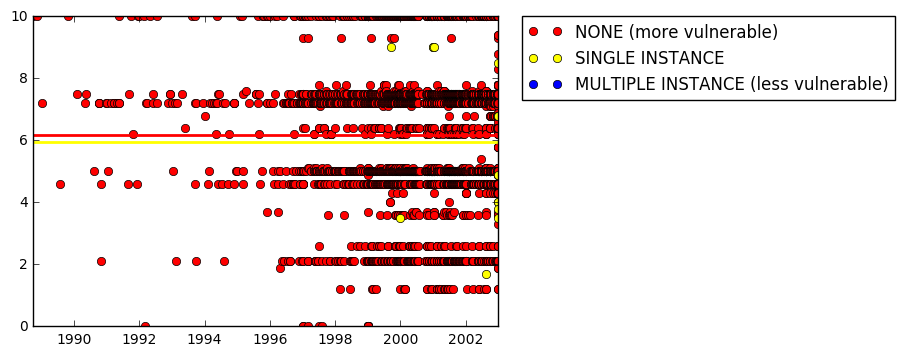

In [19]:
auth_vect = data[["score", "published_datetime", "authentication_score"]].dropna().sort_values("published_datetime")

none_data = auth_vect[auth_vect["authentication_score"] == "NONE"]
single_data = auth_vect[auth_vect["authentication_score"] == "SINGLE_INSTANCE"]
multiple_data = auth_vect[auth_vect["authentication_score"] == "MULTIPLE_INSTANCE"]


plt.plot(none_data["published_datetime"], none_data["score"], 'o', color='red')
plt.plot(single_data["published_datetime"], single_data["score"], 'o', color='yellow')
plt.plot(multiple_data["published_datetime"], multiple_data["score"], 'o', color='blue')
plt.legend(["NONE (more vulnerable)","SINGLE INSTANCE","MULTIPLE INSTANCE (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(none_data["score"]), color='red', lw=2)
plt.axhline(np.mean(single_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(multiple_data["score"]), color='blue', lw=2)

print("None score (more vulnerable) mean: " + str(np.mean(none_data["score"])))
print("Single instance score mean: " + str(np.mean(single_data["score"])))
print("Multiple instance (less vulnerable) mean: " + str(np.mean(multiple_data["score"])))

print("------------")

print("None score (more vulnerable) count: " + str(none_data["score"].count()))
print("Single instance score count: " + str(single_data["score"].count()))
print("Multiple instance (less vulnerable) count: " + str(multiple_data["score"].count()))

In [20]:
data["confidentiality_impact_score"].unique()

array(['NONE', 'COMPLETE', 'PARTIAL', nan], dtype=object)

Complete score (more vulnerable) mean: 8.44769736842
Partial score mean: 5.99950418345
None score (more vulnerable) mean: 4.3931466031
------------
Complete score (more vulnerable) count: 1520
Partial score count: 3227
None score (less vulnerable) count: 1678


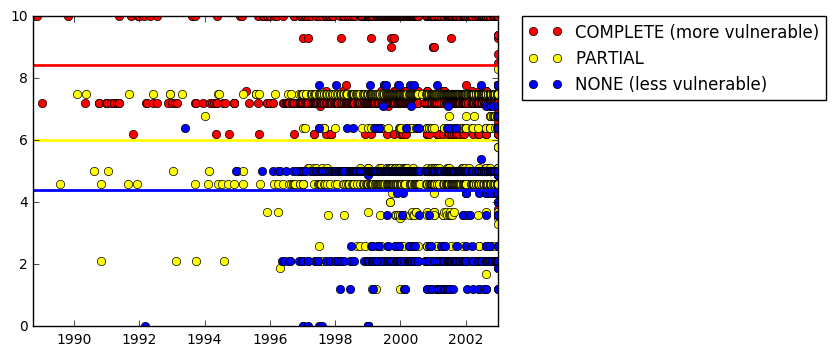

In [21]:
conf_vect = data[["score", "published_datetime", "confidentiality_impact_score"]].dropna().sort_values("published_datetime")

none_data = conf_vect[conf_vect["confidentiality_impact_score"] == "NONE"]
partial_data = conf_vect[conf_vect["confidentiality_impact_score"] == "PARTIAL"]
complete_data = conf_vect[conf_vect["confidentiality_impact_score"] == "COMPLETE"]


plt.plot(complete_data["published_datetime"], complete_data["score"], 'o', color='red')
plt.plot(partial_data["published_datetime"], partial_data["score"], 'o', color='yellow')
plt.plot(none_data["published_datetime"], none_data["score"], 'o', color='blue')

plt.legend(["COMPLETE (more vulnerable)","PARTIAL","NONE (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(complete_data["score"]), color='red', lw=2)
plt.axhline(np.mean(partial_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(none_data["score"]), color='blue', lw=2)

print("Complete score (more vulnerable) mean: " + str(np.mean(complete_data["score"])))
print("Partial score mean: " + str(np.mean(partial_data["score"])))
print("None score (more vulnerable) mean: " + str(np.mean(none_data["score"])))


print("------------")

print("Complete score (more vulnerable) count: " + str(complete_data["score"].count()))
print("Partial score count: " + str(partial_data["score"].count()))
print("None score (less vulnerable) count: " + str(none_data["score"].count()))

In [22]:
data["integrity_impact_score"].unique()

array(['NONE', 'COMPLETE', 'PARTIAL', nan], dtype=object)

Complete score (more vulnerable) mean: 8.45620871863
Partial score mean: 6.17771239426
None score (more vulnerable) mean: 4.54958941606
------------
Complete score (more vulnerable) count: 1514
Partial score count: 2719
None score (less vulnerable) count: 2192


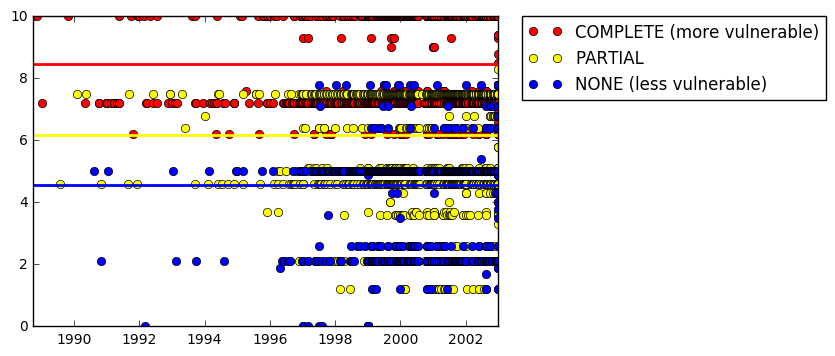

In [23]:
int_vect = data[["score", "published_datetime", "integrity_impact_score"]].dropna().sort_values("published_datetime")

none_data = int_vect[int_vect["integrity_impact_score"] == "NONE"]
partial_data = int_vect[int_vect["integrity_impact_score"] == "PARTIAL"]
complete_data = int_vect[int_vect["integrity_impact_score"] == "COMPLETE"]


plt.plot(complete_data["published_datetime"], complete_data["score"], 'o', color='red')
plt.plot(partial_data["published_datetime"], partial_data["score"], 'o', color='yellow')
plt.plot(none_data["published_datetime"], none_data["score"], 'o', color='blue')

plt.legend(["COMPLETE (more vulnerable)","PARTIAL","NONE (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(complete_data["score"]), color='red', lw=2)
plt.axhline(np.mean(partial_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(none_data["score"]), color='blue', lw=2)

print("Complete score (more vulnerable) mean: " + str(np.mean(complete_data["score"])))
print("Partial score mean: " + str(np.mean(partial_data["score"])))
print("None score (more vulnerable) mean: " + str(np.mean(none_data["score"])))


print("------------")

print("Complete score (more vulnerable) count: " + str(complete_data["score"].count()))
print("Partial score count: " + str(partial_data["score"].count()))
print("None score (less vulnerable) count: " + str(none_data["score"].count()))

In [24]:
data["availability_impact_score"].unique()

array(['PARTIAL', 'COMPLETE', 'NONE', nan], dtype=object)

Complete score (more vulnerable) mean: 8.42485511912
Partial score mean: 6.0224691358
None score (more vulnerable) mean: 4.27450980392
------------
Complete score (more vulnerable) count: 1553
Partial score count: 3240
None score (less vulnerable) count: 1632


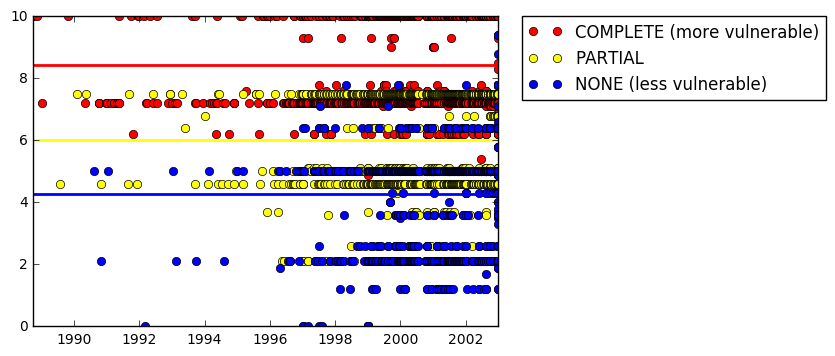

In [25]:
avail_vect = data[["score", "published_datetime", "availability_impact_score"]].dropna().sort_values("published_datetime")

none_data = avail_vect[avail_vect["availability_impact_score"] == "NONE"]
partial_data = avail_vect[avail_vect["availability_impact_score"] == "PARTIAL"]
complete_data = avail_vect[avail_vect["availability_impact_score"] == "COMPLETE"]


plt.plot(complete_data["published_datetime"], complete_data["score"], 'o', color='red')
plt.plot(partial_data["published_datetime"], partial_data["score"], 'o', color='yellow')
plt.plot(none_data["published_datetime"], none_data["score"], 'o', color='blue')

plt.legend(["COMPLETE (more vulnerable)","PARTIAL","NONE (less vulnerable)"], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.axhline(np.mean(complete_data["score"]), color='red', lw=2)
plt.axhline(np.mean(partial_data["score"]), color='yellow', lw=2)
plt.axhline(np.mean(none_data["score"]), color='blue', lw=2)

print("Complete score (more vulnerable) mean: " + str(np.mean(complete_data["score"])))
print("Partial score mean: " + str(np.mean(partial_data["score"])))
print("None score (more vulnerable) mean: " + str(np.mean(none_data["score"])))


print("------------")

print("Complete score (more vulnerable) count: " + str(complete_data["score"].count()))
print("Partial score count: " + str(partial_data["score"].count()))
print("None score (less vulnerable) count: " + str(none_data["score"].count()))